# Visual Search using Rekognition

In [1]:
# initialise Notebook
import imageio
imageio.plugins.ffmpeg.download()
import boto3
from IPython.display import HTML, display
from PIL import Image, ImageDraw, ImageFont
from pprint import pprint
from io import BytesIO
import numpy as np
import moviepy.editor as mpy
import os
import uuid
import io
import tabulate
import requests

YOUR_ACCESS_KEY='###################'
YOUR_SECRET_KEY='############################################'
REGION = 'us-west-2'

# key variable initiation
rekognition = boto3.client('rekognition', region_name=REGION,
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)
dynamodb = boto3.resource('dynamodb', region_name=REGION,
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)
s3 = boto3.client('s3', region_name=REGION,
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)


# Setting up ElasticSearch
For the first time, uncomment the cli command, run it and again comment it 

In [21]:
%%bash
#Creating Elasticsearch Domain

#aws es create-elasticsearch-domain --domain-name catalogsearch --elasticsearch-cluster-config  InstanceType=m4.large.elasticsearch,InstanceCount=1 --ebs-options EBSEnabled=true,VolumeType=gp2,VolumeSize=10


DOMAINSTATUS	arn:aws:es:us-west-2:681445445985:domain/testsearch		True	False	681445445985/testsearch	testsearch	1.5	True
ADVANCEDOPTIONS	true
EBSOPTIONS	True	10	gp2
ELASTICSEARCHCLUSTERCONFIG	False	1	m4.large.elasticsearch	False
SNAPSHOTOPTIONS	0


In [2]:
#ElasticSearch setup
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

host = 'search-catalogsearch-uij3n5mhxjujok5vjhdhfkrk5u.us-west-2.es.amazonaws.com'
awsauth = AWS4Auth(YOUR_ACCESS_KEY, YOUR_SECRET_KEY, REGION, 'es')

es = Elasticsearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)

# Ceate Elastic Search Index

In [ ]:
#es.indices.delete(index="temp-index")



In [3]:
from cStringIO import StringIO
def getImageLabels(image_location):
    with open(image_location, 'rb') as image:
        ret = rekognition.detect_labels(Image = {'Bytes': image.read()},
            MinConfidence=85)

    labels = ret['Labels']


    buf = StringIO()

    j = 0
    for label in labels:
    #    data_dict[header[i]] = row[i]
        buf.write(' ')
        buf.write(label['Name'])
        j = j+1

    return buf

In [4]:
from IPython.display import HTML, display

def handle_submit(sender):
    buf = getImageLabels(inputtext.value)
    size = 200,200
    image_bin=Image.open(inputtext.value)
    image_bin.thumbnail(size, Image.ANTIALIAS)
    print('This is the image we are searching with')
    display(image_bin)
    showRelevantImages(buf)
    
def showRelevantImages(buf):
    res = es.search(index="temp-index", body={"query": {"match": {"tags":buf.getvalue()}}})
    keys = {}
    i=0
    for hit in res['hits']['hits']:
        dict1 = hit["_source"]
        keys[i] = dict1["image"]
        i = i + 1

    bucket = 'ai-demo-in'

    # Output image and labels
    orig_image_location = '/tmp'   
    file_name = 'img_file'
    
    html = '<HTML><TABLE>'
    print('Matched Images.')
    ind = 0
    cnt = 0
    for key in keys:
        cnt += 1
        image_location = orig_image_location + '/' + file_name + str(cnt) + '.jpg'
        
        s3.download_file(bucket, keys[key], image_location)

        size = 200,200
        
        image_bin=Image.open(image_location)
        image_bin.thumbnail(size, Image.ANTIALIAS)
        
        image_bin.save(file_name + str(cnt) + ".thumbnail", "JPEG")
        
        #display(image_bin)
        
        if ind==0:
            html += '<tr>'

        html += '<td><img src=\''+ file_name + str(cnt) +'.thumbnail\' /></td>'
        ind += 1

        if ind==2:
            html += '</tr>'
            ind = 0
        #display(image_bin)
    html += '</TABLE></HTML>'
    #pprint(ret['Labels'])
    display(HTML(html))


This is the image we are searching with


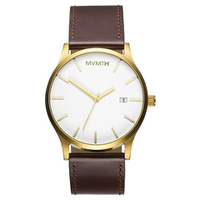

Matched Images.


,
,
,


In [5]:
from IPython.display import display 
from IPython.html import widgets
inputtext = widgets.Textarea()

display(inputtext)

inputbutton = widgets.Button(description='Search Similar Product')

display(inputbutton)

outputlabel_0 = widgets.HTML()
outputlabel_1 = widgets.HTML()
display(outputlabel_0)
display(outputlabel_1)

inputbutton.on_click(handle_submit)